
So last time in file:///Users/michal/Dropbox/Code/repo/restaurant-menu-entities/2023-12-03-menu-entities.html , we looked at paraphrase mining only on a 1000-samples from the full 403,240 set. 

Also lets look at the other dataset here, https://www.kaggle.com/datasets/prashant111/discover-the-menu , maybe there are more dishes in there as opposed to the Kaggle Uber Eats dataset, which had a lot of non food items in there. 

In [56]:
import pandas as pd
import json
from pathlib import Path
from dotenv import dotenv_values
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import semantic_search, cos_sim
import torch

DATA_DIR = dotenv_values()["DATA_DIR"]
HF_TOKEN = dotenv_values()["HF_TOKEN"]

dishdf = pd.read_csv(Path(DATA_DIR) / "kaggle-discover-the-menu/archive/dish.csv")
menuitemdf = pd.read_csv(Path(DATA_DIR) / "kaggle-discover-the-menu/archive/menuitem.csv")
menudf = pd.read_csv(Path(DATA_DIR) / "kaggle-discover-the-menu/archive/menu.csv")
menupagedf = pd.read_csv(Path(DATA_DIR) / "kaggle-discover-the-menu/archive/menupage.csv")
metadata = json.loads((Path(DATA_DIR) / "kaggle-discover-the-menu/archive/datapackage.json").read_text())

In [7]:
metadata

{'name': 'data-society_discover-the-menu',
 'title': 'Discover The Menu',
 'description': "Data includes 45,000 menus from the 1840s to the present.\n\n## Data generated through NYPL's crowdsourcing project *What's on the menu?*\n\nHere you will find The New York Public Library's transcribed historical restaurant menus, dish by dish, so that they can be searched by what people were eating back in the day. With approximately 45,000 menus dating from the 1840s to the present, The New York Public Library’s restaurant menu collection is one of the largest in the world, used by historians, chefs, novelists and everyday food enthusiasts. \n\nThe New York Public Library’s menu collection, housed in the Rare Book Division, originated through the energetic efforts of Miss Frank E. Buttolph (1850-1924), who, in 1900, began to collect menus on the Library's behalf. Miss Buttolph added more than 25,000 menus to the collection, before leaving the Library in 1924. The collection has continued to gro

## Understand this data better 
From http://menus.nypl.org/data , https://github.com/NYPL/menus-api/issues , ( old link http://api.menus.nypl.org/ that points to the defuct https://nypl.github.com/menus-api   )


Seeing they also refer to https://menupages.com/restaurants/ny-new-york  , peripherally , with a search attempt, http://www.menupages.com/restaurants/food/Broiled+green+bluefish,+Julienne+potatoes/all-areas/all-neighborhoods/all-cuisines/  , 

and http://www.epicurious.com/tools/searchresults?search=Broiled+green+bluefish,+Julienne+potatoes 
and google recipe http://www.google.com/search?tbm=rcp&q=Broiled+green+bluefish,+Julienne+potatoes 


In [8]:
dishdf.shape

(426740, 9)

In [27]:
dishdf.sample(n=10).head()

,id,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
194317,247140,Shrimp Sushi (Ebi),NaN,2,2,1985,1987,0.0,0.0
199686,254456,Chardonnay: Chateau Montelena,NaN,1,1,1987,1987,28.0,28.0
171801,216722,Dokator,NaN,1,1,1974,1974,0.0,0.0
264715,333844,Kraft American Cheese with Toasted Crackers,NaN,1,1,1941,1941,0.0,0.0
137788,172257,"Kalbssteak ""Florida"" mit glacierten Fruchten,...",NaN,1,1,0,0,0.0,0.0


## When are these dishes from? 

There appears to be items with this special year, `2928` , so filtering that out, 

/var/folders/kw/2jghyyfs17d7_bcj4d08y9jw0000gn/T/ipykernel_78933/2497576364.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


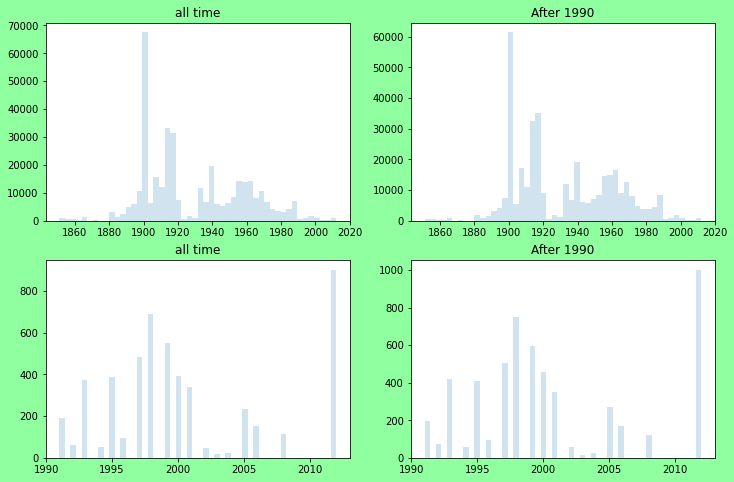

In [24]:
max_year = 2928
fig, axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
fig.patch.set_facecolor("xkcd:mint green")
ax = axes[0][0]
ax.hist(dishdf[(dishdf.first_appeared > 1) & (dishdf.first_appeared < max_year)]["first_appeared"], bins=50, alpha=0.2)
ax.set(title="all time")

ax = axes[0][1]
ax.hist(dishdf[(dishdf.last_appeared > 1) & (dishdf.last_appeared < max_year)]["last_appeared"], bins=50, alpha=0.2)
ax.set(title="After 1990")

ax = axes[1][0]
ax.hist(dishdf[(dishdf.first_appeared > 1990) & (dishdf.first_appeared < max_year)]["first_appeared"], bins=50, alpha=0.2)
ax.set(title="all time")

ax = axes[1][1]
ax.hist(dishdf[(dishdf.last_appeared > 1990) & (dishdf.last_appeared < max_year)]["last_appeared"], bins=50, alpha=0.2)
ax.set(title="After 1990")

fig.show()

In [23]:
sorted(dishdf.first_appeared.tolist())[-5:], sorted(dishdf.last_appeared.tolist())[-5:]

([2928, 2928, 2928, 2928, 2928], [2928, 2928, 2928, 2928, 2928])

## Paraphrase mining on these dishes, 

In [32]:
%%time
model_name = "all-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

sentences = dishdf["name"].sample(10000).tolist()

paraphrases = util.paraphrase_mining(model, sentences)


CPU times: user 1min 56s, sys: 2.5 s, total: 1min 58s
Wall time: 1min 4s


In [36]:
for paraphrase in [row for row in paraphrases if row[0] < .99999][:10]:
    score, i, j = paraphrase
    print("\"{}\" and \"{}\", Score: {:.4f}".format(sentences[i], sentences[j], score))


"1/2 jg. Masthahnchen mit pommees frites und Salat" and "1/2 jg. Masthahnchen mit pommes frites und Salat", Score: 0.9983
"Clam broth, per cup, with egg" and "Clam broth, per cup with egg", Score: 0.9967
"Spring lamb stew, Dublin style" and "Spring Lamb Stew, Dublin Style`", Score: 0.9912
"雞片魚肚湯" and "紫菜蛋湯", Score: 0.9911
"Spring chicken broiled" and "Broiled spring chicken", Score: 0.9894
"Bacon, One Egg and Potatoes" and "bacon, one egg, potatoes", Score: 0.9889
"STEAK OR CHICKEN FAJITA SALAD A crispy tortilla shell filled with garden greens, slices of char-broiled marinated steak or chicken breast with Cheddar, green onions, pico de gallo & sour cream" and "STEAK OR CHICKEN FAJITA SALAD A crispy tortilla shell filled with garden greens, slices of char-broiled marinated steak with Cheddar, green onions, pico de gallo & sour cream", Score: 0.9887
"Forster Half Schoppen, with Seltzer" and "Forster Half Schoppen with seltzer", Score: 0.9887
"Green-turtle soup a l'anglaise" and "Green Tu

In [37]:
for paraphrase in [row for row in paraphrases if row[0] < .95][:10]:
    score, i, j = paraphrase
    print("\"{}\" and \"{}\", Score: {:.4f}".format(sentences[i], sentences[j], score))


"Chicken okra (soup)" and "Okra with Chicken Soup", Score: 0.9494
"Fresh Orange Juice, Glass" and "Orange Juice, Glass", Score: 0.9490
"Chicken okra (soup)" and "Soup, Chicken, with Okra", Score: 0.9490
"COURVOISIER, V S O P" and "Courvoisier V S O P", Score: 0.9488
"Gefuelte Fish, Beet Horseradish" and "Gefuelte Fish with Beets and Horseradish", Score: 0.9477
"Terrapin, A La Maryland" and "Terrapin, Maryland I", Score: 0.9475
"Anheuser-Busch Budweiser Beer" and "Anheuser-Busch Budweiser", Score: 0.9474
"紫菜蛋湯" and "鳳尾蝦", Score: 0.9468
"排骨" and "鳳尾蝦", Score: 0.9465
"Soup, Cream Tomato" and "Soup, Cream of tomatoes", Score: 0.9464


## Search for Chicken parmesan

In [42]:
# (note the wayI did this below is not ideal since I lost the id when sampling)
corpus = dishdf["name"].sample(10000).tolist()
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)


query: chicken parmesan torch.return_types.topk(
values=tensor([0.7766, 0.6487, 0.6295, 0.6153, 0.6121]),
indices=tensor([ 675, 6851, 6564, 5283, 3379])) 


query: cheesy poultry sandwich torch.return_types.topk(
values=tensor([0.8070, 0.7523, 0.7196, 0.6868, 0.6724]),
indices=tensor([6564, 8770, 2176, 2929, 3399])) 


query: turkey reggiano torch.return_types.topk(
values=tensor([0.7313, 0.7079, 0.6319, 0.6115, 0.6003]),
indices=tensor([6984, 6753, 3238, 9002, 3378])) 


query: turkey pecorino torch.return_types.topk(
values=tensor([0.6900, 0.6344, 0.6254, 0.5985, 0.5967]),
indices=tensor([6753, 3238, 1811, 3978, 5161])) 


query: pollo pecorino sandwich torch.return_types.topk(
values=tensor([0.6215, 0.5948, 0.5629, 0.5587, 0.5170]),
indices=tensor([3685, 7333, 7656, 1300, 7556])) 




In [47]:
%%time
queries = ["chicken parmesan", "cheesy poultry sandwich", "turkey reggiano", "turkey pecorino", "pollo pecorino sandwich"]
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)    
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_k = 5
    top_results = torch.topk(cos_scores, k=top_k)
    print("query:",query, [[corpus[i], score] for (score, i) in zip(top_results[0], top_results[1])], "\n\n")



query: chicken parmesan [['Chicken Parmigian, with spaghetti', tensor(0.7766)], ['Chicken Salad Pita', tensor(0.6487)], ['Sandwich chicken', tensor(0.6295)], ['Chicken fricassee', tensor(0.6153)], ['CHICKEN PAPRIKASH, Parsley Potatoes', tensor(0.6121)]] 


query: cheesy poultry sandwich [['Sandwich chicken', tensor(0.8070)], ['Chicken [sandwich]', tensor(0.7523)], ['Chicken, Sardines Sandwich', tensor(0.7196)], ['Egg (fried) sandwich', tensor(0.6868)], ['Chicken sandwich with lettuce', tensor(0.6724)]] 


query: turkey reggiano [['Reggiano', tensor(0.7313)], ['turkey', tensor(0.7079)], ['roast turkey', tensor(0.6319)], ['Spring turkey (half)', tensor(0.6115)], ['Creamed Smoked Turkey, Divan-Parisienne', tensor(0.6003)]] 


query: turkey pecorino [['turkey', tensor(0.6900)], ['roast turkey', tensor(0.6344)], ['Grilled Squab turkey', tensor(0.6254)], ['Turkey poele and celery', tensor(0.5985)], ['Grilled Young turkey', tensor(0.5967)]] 


query: pollo pecorino sandwich [['Spooned "pecori

In [46]:
top_results

torch.return_types.topk(
values=tensor([0.7766, 0.6487, 0.6295, 0.6153, 0.6121]),
indices=tensor([ 675, 6851, 6564, 5283, 3379]))

## Look at this data model for one dish

In [48]:
# Looking up https://menus.nypl.org/dishes/415513 
# mentions this menu, https://menus.nypl.org/menus/32265 , 
dishdf[dishdf.id == 415513].iloc[0]


id                                                    415513
name              Broiled green bluefish, Julienne potatoes 
description                                              NaN
menus_appeared                                             1
times_appeared                                             1
first_appeared                                          2928
last_appeared                                           2928
lowest_price                                            0.65
highest_price                                           0.65
Name: 333811, dtype: object

In [50]:
menuitemdf.iloc[:5]

,id,menu_page_id,price,high_price,dish_id,created_at,updated_at,xpos,ypos
0,1,1389,0.4,NaN,1.0,2011-03-28 15:00:44 UTC,2011-04-19 04:33:15 UTC,0.111429,0.254735
1,2,1389,0.6,NaN,2.0,2011-03-28 15:01:13 UTC,2011-04-19 15:00:54 UTC,0.438571,0.254735
2,3,1389,0.4,NaN,3.0,2011-03-28 15:01:40 UTC,2011-04-19 19:10:05 UTC,0.140000,0.261922
3,4,1389,0.5,NaN,4.0,2011-03-28 15:01:51 UTC,2011-04-19 19:07:01 UTC,0.377143,0.262720
4,5,3079,0.5,1.0,5.0,2011-03-28 15:21:26 UTC,2011-04-13 15:25:27 UTC,0.105714,0.313178


In [51]:
menuitemdf[menuitemdf.dish_id == 415513]

,id,menu_page_id,price,high_price,dish_id,created_at,updated_at,xpos,ypos
1068891,1116293,66700,0.65,NaN,415513.0,2012-09-25 22:26:46 UTC,2012-10-14 15:28:18 UTC,0.105333,0.29552


In [57]:
menupagedf[menupagedf.id == 66700]


,id,menu_id,page_number,image_id,full_height,full_width,uuid
56205,66700,32265,1.0,4049510,7170.0,3876.0,c37c22b3-25b0-835e-e040-e00a18066b39


In [58]:
menudf[menudf.id == 32265]

,id,name,sponsor,event,venue,place,physical_description,occasion,notes,call_number,keywords,language,date,location,location_type,currency,currency_symbol,status,page_count,dish_count
14659,32265,Healy's Forty-second Street restaurant,Healy's Forty-second Street restaurant,NaN,NaN,NaN,33x18cm,NaN,dinner,1918-0387_wotm,NaN,NaN,2928-03-26,Healy's Forty-second Street restaurant,NaN,Dollars,$,complete,2,333


## Plan for the demo update 
- Ok lets dump the dish embeddings to a embedding file based vector db. Maybe that is chroma. 
- Then update my app.py to query against that file vector db therefore.
- And I can add the relational classic part to the query, such that, can search for restaurants, say, within a particular geographic area. (Maybe cuisine if I can see cuisine somewhere in here too ) 


### Storing those embeddings
So is the huggingface datasets approach , https://huggingface.co/blog/getting-started-with-embeddings#2-host-embeddings-for-free-on-the-hugging-face-hub , private ? 



In [60]:
corpus_embeddings[:2,:3]

tensor([[-0.1169,  0.0806, -0.1439],
        [-0.0150, -0.0498, -0.0485]])

#### Ah ok, it is a tensor because I chose the `convert_to_tensor=True` option I think in `model.encode`
```python
corpus = dishdf["name"].sample(10000).tolist()
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
```

#### Ok here is the uri
https://huggingface.co/datasets/namoopsoo-org/nypl-dishes-2023-12-17

In [61]:
%%time
dishdf_sample_10k = dishdf.sample(10000)
corpus = dishdf_sample_10k["name"].tolist()
corpus_embeddings = model.encode(corpus, convert_to_tensor=False)
# corpus_embeddings # 10k sample

CPU times: user 1min 50s, sys: 2.85 s, total: 1min 53s
Wall time: 59.5 s


In [69]:
corpus_embeddings

array([[ 4.6341040e-05,  6.3488330e-03, -3.9927596e-03, ...,
        -5.0374635e-02, -3.0236701e-02,  4.3697987e-02],
       [-2.6026350e-02,  1.7899187e-02, -1.5278223e-01, ...,
        -8.8468477e-02,  2.7734280e-02, -3.4045678e-02],
       [-6.3904420e-02, -1.0652682e-02, -1.7555350e-02, ...,
         5.8307756e-02,  9.3813606e-02,  9.6471556e-02],
       ...,
       [-8.6855069e-03,  5.7526581e-02,  3.2956218e-03, ...,
         6.8702735e-02, -2.2665113e-02, -4.4143491e-04],
       [ 1.4353356e-02,  9.4276562e-02, -2.6659792e-02, ...,
         4.0872402e-02, -1.8203659e-02, -8.9903409e-03],
       [ 1.4015907e-02, -7.5870351e-04, -9.3282899e-03, ...,
         1.1273289e-01,  6.6884801e-02, -9.3462624e-02]], dtype=float32)

In [66]:
!ls

2023-12-03-menu-entities.html  jovyan_utils.py
2023-12-03-menu-entities.ipynb nypl-dishes-2023-12-17
2023-12-17.ipynb               requirements.txt
README.md                      restaurant-menus.csv
__pycache__                    restaurants.csv
app.py                         utils.py


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [71]:
pd.DataFrame(corpus_embeddings).to_csv("nypl-dishes-2023-12-17/sample-10k.csv", index=False)

In [81]:
dishdf_sample_10k.to_csv("nypl-dishes-2023-12-17/sample-10k-dishdf.csv", index=False)

In [72]:
corpus_embeddings_from_csv = torch.from_numpy(pd.read_csv("nypl-dishes-2023-12-17/sample-10k.csv").to_numpy()).to(torch.float)

# Try that search again, 
query = "chicken parmesan"
query_embedding = model.encode(query, convert_to_tensor=True)    
cos_scores = util.cos_sim(query_embedding, corpus_embeddings_from_csv)[0]
top_k = 5
top_results = torch.topk(cos_scores, k=top_k)
print("query:",query, [[corpus[i], score] for (score, i) in zip(top_results[0], top_results[1])], "\n\n")



query: chicken parmesan [['Chicken with Parsley sauce', tensor(0.7046)], ['Essence of Chicken and Mushrooms, Vermicelli Croutons Parmesan', tensor(0.6430)], ['Chicken en casserole, Parmentier', tensor(0.6272)], ['Chicken cutlets, baked parsley', tensor(0.6134)], ['Spaghetti Bolognese Parmesan', tensor(0.6086)]] 




### Lets try to load w/ datasets also 


In [75]:
from datasets import load_dataset

loaded_embeddings = load_dataset("namoopsoo-org/nypl-dishes-2023-12-17")
# https://huggingface.co/datasets/namoopsoo-org/nypl-dishes-2023-12-17/blob/main/sample-10k.csv

/Users/michal/opt/miniconda3/envs/pandars310/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [77]:
loaded_embeddings["train"].shape

(10000, 384)

In [80]:
corpus_embeddings = torch.from_numpy(
    loaded_embeddings["train"].to_pandas().to_numpy()
).to(torch.float)

# Try that search again, 
query = "chicken parmesan sandwich"
query_embedding = model.encode(query, convert_to_tensor=True)    
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_k = 5
top_results = torch.topk(cos_scores, k=top_k)
print("query:", query, [[corpus[i], score] for (score, i) in zip(top_results[0], top_results[1])], "\n\n")



query: chicken parmesan sandwich [['Chicken, toasted sandwich', tensor(0.7108)], ['Chicken and Ham Sandwich', tensor(0.7056)], ['All White Meat Sliced Chicken Sandwich', tensor(0.7028)], ['Chicken and lettuce sandwich', tensor(0.6918)], ['Hot Chicken Sandwich, White Meat', tensor(0.6683)]] 




In [83]:
tryagain = load_dataset("namoopsoo-org/nypl-dishes-2023-12-17")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Note on datasets 
So yea you can only have one file per dataset repo or they should have the same schema , otherwise you get 

```
load_dataset("blahblah")
```
```
DatasetGenerationError: An error occurred while generating the dataset

```

In [ ]:
# 
# load_dataset("namoopsoo-org/nypl-dishes-2023-12-17")
